### 聚类

In [1]:
# 分类和回归都属于监督学习，特点是都有一个标注，而标注的存在就是给分类任务或者回归任务一个指引，告诉算法具备什么样特征的数据是什么样的标注，也就是叫什么样的名字，哪些数据是一样的，哪些是不一样的，都是通过标注来进行区分的。
# 无监督学习（无标注）
    # 目的是试图给这些数据加上标注。
    # 打标注的原则：就是希望给没有标注的数据加上标注后，同一个标注内的数据尽可能的相似，不同标注内的数据尽可能的不同。即便如此，由于目的不同，方法不同，导致相似和不同的方式也就不一样。这样就导致了不同的算法。
    # 使用最多的算法：
        # 聚类算法：
            # 1.基于切割的K-means:所有类都有一个中心，属于一个类的点到它的中心的距离是相比于其它类的中心更近。确定中心的方法，取数据各个维度的均值。
                # a)从样本中随机选取k个作为初始化的质心
                # b)对每个样本测量其到每个质心的距离，并把它归到最近的质心的类
                # c)重新计算已经得到的各个类的质心
                # d)迭代b~c步直至新的质心于原质心相等或小于指定的阈值，算法结束 
                # 问题：
                    # 1.初始质心的位置可能会影响最终的聚类结果。解决思路：多试几次，取最稳定的结果
                    # 2.个别离群值会影响整体聚类的效果。解决思路：将取质心换成取中点（K-Medoids）.K-Medoids中点：是距它同类点的距离和最小
                    # 3.必须要指定K。解决思路：其它衡量因子辅助（如轮廓系数、对角误差）
            # 2.基于层次的聚类
            # 3.基于密度的DBSCAN
            # 4.基于图的Split
        # 关联规则

#### 代码实现 K-means算法

In [8]:
import numpy as np
import matplotlib.pyplot as plt
# 引入生成点的函数
from sklearn.datasets import make_circles, make_blobs, make_moons
# 引入K-means, DBSCAN，层次聚类
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
# 定义样本点个数
n_samples = 1000

/Applications/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


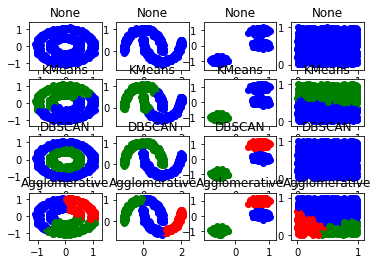

In [9]:
# noise 噪声
# factor 小圆和大圆之间的间距
circles = make_circles(n_samples=n_samples, factor=0.5, noise=0.05)
moons = make_moons(n_samples=n_samples, noise=0.05)
# random_state 确保每次生成的值都一样 
# center_box默认值是（-10，10）y轴的值
# cluster_std 标准差，默认为1.0
blobs = make_blobs(n_samples=n_samples, random_state=8, center_box=(-1, 1), cluster_std=0.1)
# 指定随机值
random_data = np.random.rand(n_samples, 2), None
# print(circles)
# 指定要使用的色系
colors = "bgrcmyk"
# 定义数据集
data = [circles, moons, blobs, random_data]
# 定义模型 [(模型的名字,模型的实体)]
# n_clusters 分成几类
# min_samples 最小点数
# eps E邻域
# linkage 簇之间的连接方式 average:平均距离  complete:最大距离
models = [("None", None), ("KMeans", KMeans(n_clusters=2)), 
          ("DBSCAN", DBSCAN(min_samples=3, eps=0.2)),
         ("Agglomerative", AgglomerativeClustering(n_clusters=3, linkage="ward"))]
f = plt.figure()
# inx 下标
# clt 模型
for inx, clt in enumerate(models):
    # 获取名字和实体
    clt_name, clt_entity = clt
    for i, dataset in enumerate(data):
        # X是数据，Y是标注
        X, Y = dataset
        # 如果实体为空 直接赋值为0
        if not clt_entity:
            clt_res = [0 for item in range((len(X)))]
        else:
            # 拟合，也就是聚类的过程
            clt_entity.fit(X)
            # 获取labels(聚类的结果)并转换成int格式
            clt_res = clt_entity.labels_.astype(np.int)
        # 画图
        f.add_subplot(len(models), len(data), inx*len(data)+i+1)
        plt.title(clt_name)
        # 散点图 同样的标注会被附上同样的颜色，不同的标注就会被附上不同的颜色
        [plt.scatter(X[p, 0], X[p, 1], color=colors[clt_res[p]]) for p in range(len(X))]
plt.show()

### 聚类DBSCAN

In [1]:
# 基于密度的聚类算法 DBSCAN：假设一定区域内密度达到一定的程度，它才是一个类，否则只能叫离群点。
# 问题：
    # 1.这个区域到底有多大
    # 2.我们指定的密度有多大
# E邻域：给定对象半径为E内的区域称为该对象的E邻域
# 核心对象：如果给定对象E邻域内的样本点数大于等于MinPts，则称该对象为核心对象
# 直接密度可达：对于样本集合D，如果样本点q在p的E邻域内，并且p为核心对象，那么对象q从对象p直接密度可达
# 密度可达：对于样本集合D，给定一串样本点p1,p2...pn, p=p1, q=pn,假如对象pi从pi-1直接密度可达，那么对象q从对象p密度可达
# 密度相连：存在样本集合D中的一点o，如果对象o到对象p和对象q都是密度可达的，那么p和q密度相连
# ⚠️ DBSCAN的任务是找到密度相连对象的最大集合
# 假设我们指定了合适的半径和E邻域的点，那么它对离群点是不敏感的。解决办法：需要KD-Tree等数据结构辅助

#### 代码看上面

### 层次聚类

In [6]:
# 原理：先将最近的两个点生成一个簇，然后再有相邻的簇生成一个大簇，以此类推
# 距离衡量：
    # 最短距离
    # 最长距离
    # 平均距离
    # Ward（除以n就是方差）：用ESS(平方残差和)进行衡量，如果两个簇和在一起后，ESS越小越应该合并，反之亦然
# 优点：聚类灵活
# 缺点：计算复杂度比较高，离群点的影响比较大

#### 代码看上面

### 图分裂

In [ ]:
# 1.根据坐标点的位置关系生成连通图。可以使用DBCSCAN算法找到最大的点数，然后用边将其连接起来
# 2.再将生成的多个连通图进行逐一的分裂。可以使用两个系数：
    # 1.承受系数t=min(W1,W2)/n  n将连通图分裂开的边的个数，W1是左边的点数，W2是右边的点的个数。（n越小越不应该分开）
    # 2.r 分裂阈值（兰姆达），x是最大连通图中边的数量，y是最大连通图中点的数量  若 t>r 则应该分开（将连接的边去掉）
# 问题
    # 与基类层次聚类的思路相反，为从顶至下
    # 图建立方式、分裂方式可以非常灵活